In [1]:
%matplotlib inline
import sys,os
print(sys.version)

3.9.7 | packaged by conda-forge | (default, Sep 29 2021, 19:20:46) 
[GCC 9.4.0]


**CHANGE THE ROOT_dir FIRST ！！**

In [2]:
#The ROOT_dir is the folder contains "LateralDynamicsMetrica". 
ROOT_dir = '/home/jovyan/'

In [3]:
##########################################
###########Set the fold and import the modules#########
##########################################
os.chdir(ROOT_dir + "LateralDynamicsMetrica/codes/")
from RequiredModules import *
#
figspath = ROOT_dir + "LateralDynamicsMetrica/figs/"
dataspath = ROOT_dir + "LateralDynamicsMetrica/datas/"
#
#os.chdir("/home/jovyan/")
#import LateralSDE.codes.sde_lateral as sdelat
#os.chdir(ROOT_dir)
#import LateralDynamicsMetrica.codes.sde_lateral as sdelat

#  openACC data load and visualize

In [4]:
#######Load the data
########################LOAD the data
#data['segment'] refers to a platoon data with certain time window (set to 15 sec)
filee = dataspath + 'segments1.csv'
data = pd.read_csv(filee)
#all the labels of the segments
segments = set(data['segment'])
#select the segment '1' to see what the data looks like
segment = 1
segmentdata = data[data.segment == segment]
#x1, x2 and x3 are the x-coordinate of the three vehicles in the platoon.
segmentdata.head()

,Time,v1,Lat1,Lon1,x1,y1,v2,Lat2,Lon2,x2,...,Lat3,Lon3,x3,y3,IVS1,IVS2,Driver1,Driver2,Driver3,segment
0,0.0,27.017090,0.7838,0.144115,1002.206598,-9713.303944,26.529120,0.7838,0.144108,971.365211,...,0.783803,0.144089,885.821669,-9704.044372,26.891977,82.235276,Human,ACC,Human,1
1,0.1,27.043830,0.7838,0.144116,1004.908495,-9713.428794,26.538934,0.7838,0.144109,974.039920,...,0.783803,0.144090,889.203241,-9704.348561,26.917341,81.516237,Human,ACC,Human,1
2,0.2,27.065812,0.7838,0.144116,1007.604267,-9713.552070,26.550280,0.7838,0.144109,976.713337,...,0.783802,0.144091,892.580742,-9704.651712,26.937983,80.799853,Human,ACC,Human,1
3,0.3,27.086235,0.7838,0.144117,1010.299045,-9713.674629,26.563000,0.7838,0.144110,979.383991,...,0.783802,0.144091,895.954687,-9704.954286,26.960408,80.084325,Human,ACC,Human,1
4,0.4,27.108136,0.7838,0.144117,1013.000227,-9713.797134,26.576880,0.7838,0.144111,982.050955,...,0.783802,0.144092,899.325589,-9705.256746,26.992880,79.368322,Human,ACC,Human,1


In [5]:
######################################Extract the lateral movement as algorithm input 
#final output is accdatas, which is a dict. The keys are the data ID. 
#accdatas[idx] = pd.Series. It describes the lateral movement of the vehicle
trajectory_rotate_tolerant = 2.0#normal lane width is 3.7m, about ∓2m. 
accdatas = {}
for segment in segments:
    #First vehicle in platoon
    segmentdata = data[data.segment == segment]
    tmp = segmentdata.y1 - np.mean(segmentdata.y1)
    tmp.index = segmentdata.Time.values - min(segmentdata.Time.values)
    if not ( max(tmp)>trajectory_rotate_tolerant or min(tmp)<-trajectory_rotate_tolerant):
        accdatas[len(accdatas)] = copy.deepcopy(tmp)
    #Second vehicle in platoon
    tmp = segmentdata.y2 - np.mean(segmentdata.y2)
    tmp.index = segmentdata.Time.values - min(segmentdata.Time.values)
    if not ( max(tmp)>trajectory_rotate_tolerant or min(tmp)<-trajectory_rotate_tolerant):
        accdatas[len(accdatas)] = copy.deepcopy(tmp)
    #Third vehicle in platoon
    tmp = segmentdata.y3 - np.mean(segmentdata.y3)
    tmp.index = segmentdata.Time.values - min(segmentdata.Time.values)
    if not ( max(tmp)>trajectory_rotate_tolerant or min(tmp)<-trajectory_rotate_tolerant):
        accdatas[len(accdatas)] = copy.deepcopy(tmp)
#show the 1st data sample. The index of the series are seconds. 
print('Total openACC lateral trajectories number is --->', len(accdatas))

Total openACC lateral trajectories number is ---> 321


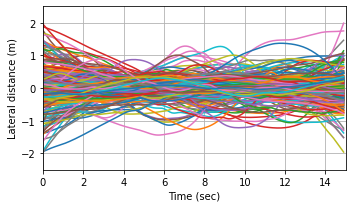

In [7]:
#############################Plot the lateral movment  of the openacc data. 
reload(sdelat)
fig,ax = plt.subplots(figsize = (5,3))
for i in accdatas.keys():
    ax.plot(accdatas[i])
#
ax.set_xlabel('Time (sec)');ax.set_ylabel('Lateral distance (m)');
ax.set_xlim([0, 15]);ax.set_ylim([-2.5, 2.5]);ax.grid('on')
plt.tight_layout();plt.savefig(figspath + 'openACC_trajectories.jpg', dpi = 800)

# highD data load, process and visualize

In [8]:
##################Load dataset into variable trs_highD
dataspath_highd  = dataspath + '/Location_1_data/'#Location1: lanemarks_coors_meter = np.array([8.75, 12.7, 16.12, 20.5, 25.1, 28.5, 33.15, 36.3])
#dataspath  = '/home/jovyan/MISC/highD_lc_lk/Location_2/'#Loacation2: lanemarks_coors_meter = np.array([8.09, 11.59, 14.5, 20.45, 23.97, 27])
trs_highD = {}
for f in os.listdir(dataspath_highd):
    if not 'Keep' in f:continue
    d = pd.read_csv(dataspath_highd + f)
    vids = set(d.id)
    for vid in vids:
        vdata = d[d.id==vid]
        trs_highD[f+ str(vid)] = copy.deepcopy(vdata[['frame', 'x', 'y']])
        trs_highD[f+ str(vid)].loc[:,'frame'] = trs_highD[f + str(vid)]['frame'].values - min(trs_highD[f + str(vid)]['frame'])

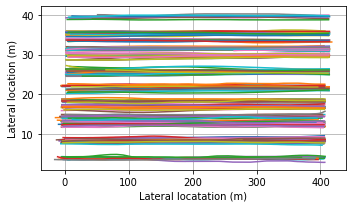

In [9]:
####################Plot the xy trajectoies
ax= sdelat.dataanalysis.plot_trs(trs_highD, N = 300, plot_x_col = 'x', plot_y_col = 'y', figsize= (5,3))
ax.grid()
ax.set_xlabel('Lateral locatation (m)');ax.set_ylabel('Lateral location (m)');plt.tight_layout()
#plt.savefig(figspath + 'highd.jpg',dpi = 500)

In [11]:
##############Translate the lateral location, such that the middle line of all trajectories is zero. 
##############The resulting variable is observations_highD, a dict. 
#Location1: lanemarks_coors_meter = np.array([8.75, 12.7, 16.12, 20.5, 25.1, 28.5, 33.15, 36.3])
#Loacation2: lanemarks_coors_meter = np.array([8.09, 11.59, 14.5, 20.45, 23.97, 27])
trs_highD_normalized = sdelat.dataanalysis.normalize_lateral_to_zero_given_dicts_of_df(trs_highD, \
        lanemarks_coors_meter = np.array([8.75, 12.7, 16.12, 20.5, 25.1, 28.5, 33.15, 36.3]),  moment_col = 'frame', lateral_col = 'y',\
        lateral_scale_to_meter = 1.0, moment_scale_to_second = .04, normalized_lw = 3.5,)
observations_highD = sdelat.dataanalysis.Convert_trs_dict2observation(trs_highD_normalized, \
                                                                      moment_col = 'frame', lateral_col = 'y', T_horizon_sec_min  = 5)
print('Total highD lateral trajectories number is ----->', len(observations_highD))

Total highD lateral trajectories number is -----> 4946


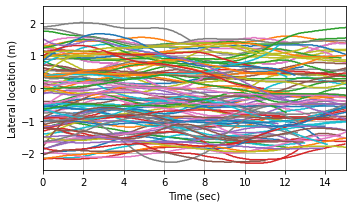

In [12]:
##################Plot the lateral dynamics of the highD trajectoirs
reload(sdelat)
plotted_samples_num = 100;ax = sdelat.dataanalysis.plot_observations(observations_highD, figsize = (5,3), N=plotted_samples_num)
ax.set_xlabel('Time (sec)');ax.set_ylabel('Lateral location (m)');plt.tight_layout()
ax.set_xlim([0, 15]);ax.set_ylim([-2.5, 2.5]);ax.grid('on')
#plt.tight_layout();plt.savefig(figspath + 'highD_lateraltrajectories.jpg', dpi = 500)

# Identification

In [15]:
reload(sdelat)
############################################################
####################################Run the estimation. ############
############################################################
#n_mcint is the Monte Carlo integration points number.  
logav_versus_logprobhdv_openACC = sdelat.DifferentiateBatch(accdatas, n_mcint = 1e5)
#Too many data of highD. We only randomly sample 321 trajectories (the same as openACC datasets)
random_selected_data = {vid:observations_highD[vid] for vid in np.random.choice(list(observations_highD.keys()), 321)}
logav_versus_logprobhdv_highD = sdelat.DifferentiateBatch(observations_dict = random_selected_data, n_mcint = 1e4 )
############################################################
###################################Print the accuracy##############
############################################################
#Print accuracy
accuracy_openacc = len(logav_versus_logprobhdv_openACC[logav_versus_logprobhdv_openACC<1.0])/len(logav_versus_logprobhdv_openACC)
print('openACC-- ', accuracy_openacc)
accuracy_highD = len(logav_versus_logprobhdv_highD[logav_versus_logprobhdv_highD>1.0])/len(logav_versus_logprobhdv_highD)
print('highD--', accuracy_highD)
print('Total-----',   (accuracy_openacc+accuracy_highD)/2.0)

openACC--  0.7009345794392523
highD-- 0.7588424437299035
Total----- 0.7298885115845779


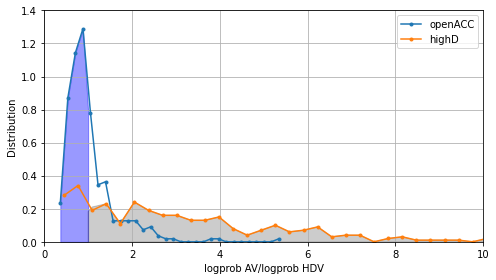

In [19]:
############################################################
####################################Plot and save the figure##########
############################################################
fig,ax = plt.subplots(figsize = (7, 4))
hs0,es = np.histogram(logav_versus_logprobhdv_openACC, bins = 30)
hs = hs0/sum(hs0)/(np.diff(es)[0])
ax.plot(es[1:], hs,  '.-', label = 'openACC')
#Fill
bin_start = np.searchsorted(es, 1.0)
extended_bins = np.concatenate(([.0] + es[:bin_start], [1],es[bin_start:]))
extended_hist, _ = np.histogram(logav_versus_logprobhdv_openACC, bins=extended_bins, density=True)
ax.fill_between(extended_bins[1:], extended_hist, where=(extended_bins[1:] <= 1), color='blue', alpha = .4,)
#########################################################################
hs0,es = np.histogram(logav_versus_logprobhdv_highD, bins = 50)
hs = hs0/sum(hs0)/(np.diff(es)[0])
ax.plot(es[1:], hs, '.-',label = 'highD')
#Fill
bin_start = np.searchsorted(es, 1.0)
extended_bins = np.concatenate((es[:bin_start], [1], es[bin_start:]))
extended_hist, _ = np.histogram(logav_versus_logprobhdv_highD, bins=extended_bins, density=True)
ax.fill_between(extended_bins[1:], extended_hist, where=(extended_bins[1:] >= 1), color='black', alpha = .2,)
#
ax.set_xlim([0, 10]);ax.set_ylim([0, 1.4])
ax.legend();ax.grid('on')
ax.set_xlabel('logprob AV/logprob HDV');ax.set_ylabel('Distribution')
plt.tight_layout();plt.savefig(figspath + 'Identifications.jpg', dpi = 500)